# Vision Foundation Models (VFM)


**[Li Li](https://www.luisli.org), Durham University, 2024**

[![](https://img.shields.io/badge/🌐%20%20%20Homepage-red??&style=flat-square)](https://www.luisli.org)
[![](https://img.shields.io/badge/Google%20Scholar-%234285F4.svg?&style=flat-square&logo=google-scholar&logoColor=white)](https://scholar.google.com/citations?user=VsdK2xwAAAAJ)
[![GitHub followers](https://img.shields.io/github/followers/l1997i)](https://github.com/l1997i)

---

**Vision Foundation Models (VFM)** are large models that you can use without prior training. You can use VFM to auto-label data for use in training a smaller, real-time vision model.
![image.png](https://i3.mjj.rip/2024/07/01/f0fd19fbfe0d497d7e6176b152883f66.png)
Figure: Illustration of using VFM for semantic superpixel-to-superpoint transformation. *(Liu et al., 2024. Segment Any Point Cloud Sequences By Distilling Vision Foundation Models. NeurIPS.)*

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- **Before you start** - Make sure you have access to the GPU
- Basic Knowledge on Sensors and Modalities for Autonomous Driving
- Install Segment Anything Model (SAM)
- Download Example Data
- Load Model
- Example: Automated Mask Generation for 2D image
- Example: Automated Mask Generation for Panoramic Images (LiDAR)
- Example: Multi-modality Fusion

## Let's begin!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems, refer to `Pro Tip: Use GPU Acceleration` (previous section).

In [ ]:
!nvidia-smi

Sun Jun 30 22:43:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Basic Knowledge on Sensors and Modalities for Autonomous Driving
![image-2.png](https://i3.mjj.rip/2024/07/01/35eca176507d911474dbeacc70b061fe.png)

Taking the [DurLAR](https://github.com/l1997i/DurLAR) autonomous driving dataset as an example (other datasets such as KITTI, nuScenes, and WOD are similar), the vision-related sensors and modalities mainly include:
- Stereo Camera
    - Left camera (RGB image)
    - Right camera (gray-scale image)
- 3D LiDAR
    - 3D point cloud
    - Ambient Panoramic Imagery
    - Reflectivity Panoramic Imagery

## Download Example Data

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


Let's download few example [DurLAR](https://github.com/l1997i/DurLAR) data.

In [ ]:
%cd {HOME}

!wget -q https://github.com/l1997i/DurLAR/raw/main/durlar_data_mini.zip
!unzip durlar_data_mini.zip

/content
Archive:  durlar_data_mini.zip
   creating: durlar_data/
   creating: durlar_data/0000000189/
  inflating: durlar_data/0000000189/0000000189_range.png  
  inflating: durlar_data/0000000189/0000000189.dur  
  inflating: durlar_data/0000000189/0000000189_rgb.png  
  inflating: durlar_data/0000000189/0000000189_ambient.png  
  inflating: durlar_data/0000000189/0000000189.bin  
  inflating: durlar_data/0000000189/0000000189_reflec.png  
  inflating: durlar_data/0000000189/0000000189_z.png  
  inflating: durlar_data/0000000189/0000000189_x.png  
  inflating: durlar_data/0000000189/0000000189_y.png  
  inflating: durlar_data/0000000189/0000000189_gray.png  
   creating: durlar_data/0000000171/
  inflating: durlar_data/0000000171/0000000171_rgb.png  
  inflating: durlar_data/0000000171/0000000171.dur  
  inflating: durlar_data/0000000171/0000000171_ambient.png  
  inflating: durlar_data/0000000171/0000000171_z.png  
  inflating: durlar_data/0000000171/0000000171_range.png  
  inflati

## Install Segment Anything Model (SAM) and other dependencies

**The Segment Anything Model (SAM)** is a novel paradigm in general-purpose image segmentation, exhibiting remarkable zero-shot transfer capabilities across a diverse array of downstream tasks. Concurrent advancements, including X-Decoder, OpenSeeD, SegGPT, and SEEM, further demonstrate the efficacy of VFM in addressing a wide spectrum of image-related challenges.

Therefore, we adopt SAM as an example among the various VFM. Applying other VFM can yield similar results.

In [ ]:
%cd {HOME}

!pip install git+https://github.com/facebookresearch/segment-anything.git

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cltrv2v9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cltrv2v9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=f22d733d5481c8f06e44436f5c4472f63f8c9432eac49a6f86c7c934591d0f03
  Stored in directory: /tmp/pip-ephem-wheel-cache-jeteojlv/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
!pip install -q supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 4.3 MB/s eta 0:00:00


### Download SAM weights

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [ ]:
import torch
import numpy as np

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Example: Automated Mask Generation for 2D image

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
def init_dataset(frame_id, feature_suffixes):
    IMAGE_NAMES = [f"{frame_id}{feature_suffix}" for feature_suffix in feature_suffixes]
    IMAGE_PATHS = [os.path.join(HOME, "durlar_data", frame_id, name) for name in IMAGE_NAMES]
    print(IMAGE_PATHS)
    return IMAGE_PATHS

In [ ]:
frame_id = "0000000189"
cam_feature_suffixes = ["_rgb.png", "_gray.png"]
CAM_IMAGE_PATHS = init_dataset(frame_id, cam_feature_suffixes)

['/content/durlar_data/0000000189/0000000189_rgb.png', '/content/durlar_data/0000000189/0000000189_gray.png']


### Generate masks with SAM

In [ ]:
import cv2
import supervision as sv

def generate_sam_masks(img_paths):
    sam_results = []
    images_bgr = []
    for img_path in img_paths:
        image_bgr = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        images_bgr.append(image_bgr)
        sam_results.append(mask_generator.generate(image_rgb))
        print(f"SAM mask has been generated: {img_path}")
    return images_bgr, sam_results

In [ ]:
cam_images_bgr, cam_sam_results = generate_sam_masks(CAM_IMAGE_PATHS)

SAM mask has been generated: /content/durlar_data/0000000189/0000000189_rgb.png
SAM mask has been generated: /content/durlar_data/0000000189/0000000189_gray.png


### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
print(cam_sam_results[0][0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation

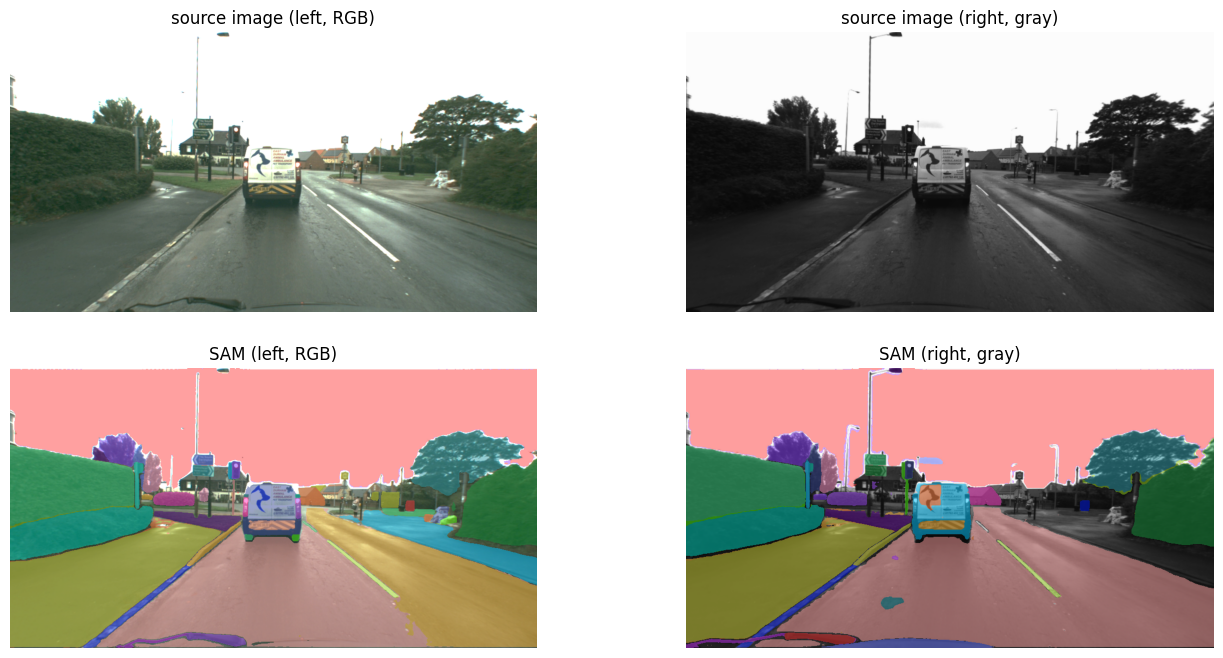

In [ ]:
annotated_images = []
for idx, sam_result in enumerate(cam_sam_results):

    mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

    detections = sv.Detections.from_sam(sam_result=sam_result)

    annotated_images.append(mask_annotator.annotate(scene=cam_images_bgr[idx].copy(), detections=detections))

annotated_images.insert(0, cam_images_bgr[0])
annotated_images.insert(1, cam_images_bgr[1])
sv.plot_images_grid(
    images=annotated_images,
    grid_size=(2, 2),
    size=(16, 8),
    titles=['source image (left, RGB)', 'source image (right, gray)', 'SAM (left, RGB)', 'SAM (right, gray)']
)

It’s quite remarkable, isn’t it? Unlike conventional models, VFM can directly infer fairly accurate segmentation results even **without being specifically trained on downstream datasets** such as DurLAR.

From the visualization above, we can observe that even for the same scene, the SAM results obtained from RGB images are significantly better than those obtained from gray images. This may be because the real-world colors provide additional assistance to SAM.

## Example: Automated Mask Generation for Panoramic Images (LiDAR)
However, the segmentation shown above is still far from sufficient for autonomous driving —- we aim to achieve **360-degree panoramic scene segmentation** to enable safe, no-blind-spot autonomous driving. Therefore, we intend to segment the point clouds collected by 3D LiDAR (The data collected by LiDAR has a broader field of view compared to that of a stereo camera).

**Directly using VFMs on 3D point clouds is usually impractical** because the current mainstream VFM are designed for 2D images. Therefore, we map the 3D point clouds to 2D images, resulting in **ambient, reflectivity, range, x, y, and z** panoramic images. All our panoramic images are obtained from the original 3D point cloud files (i.e., *.bin) and panoramic extension files (i.e., *.dur) through the 3D-to-2D projection.

The shape of the panoramic imagery is $j \times k \times 1$, where $j$ represents the number of beams emitted (for DurLAR, KITTI and nuScenes, $j=128, 64$ and $32$ respectively) and $k$ represents the number of times measurement in one scan cycle. For each pixel in the panoramic imagery, we use the following values as its pixel value (i.e., the corresponding element of the 2D matrix):
- `ambient` value collected by LiDAR. Ambient images offer day/night scene visibility in the near-infrared spectrum. Ambient images can be captured even in low light conditions. This is extremely practical in designing techniques that are specifically appropriate for adverse illumination conditions, such as nocturnal and adverse weather conditions.
- `reflectivity` value collected by LiDAR. Reflectivity images contain information indicative of the material properties of the object itself and offer good consistency across illumination conditions and range.
- `range` (i.e., depth) value computed from 3D point cloud of the corresponding point.
- `x`, `y`, `z` values from 3D point cloud of the corresponding point (i.e., `x`, `y`, `z` coordinates).

Please refer to [DurLAR paper](https://arxiv.org/abs/2406.10068) for more details on **panoramic imagery**.

In [ ]:
frame_id = "0000000189"
pano_feature_suffixes = ["_ambient.png", "_reflec.png", "_range.png", "_x.png", "_y.png", "_z.png"]
PANO_IMAGE_PATHS = init_dataset(frame_id, pano_feature_suffixes)

['/content/durlar_data/0000000189/0000000189_ambient.png', '/content/durlar_data/0000000189/0000000189_reflec.png', '/content/durlar_data/0000000189/0000000189_range.png', '/content/durlar_data/0000000189/0000000189_x.png', '/content/durlar_data/0000000189/0000000189_y.png', '/content/durlar_data/0000000189/0000000189_z.png']


To more clearly compare the differences in field of view, let’s first visualize some panoramic images and camera images.

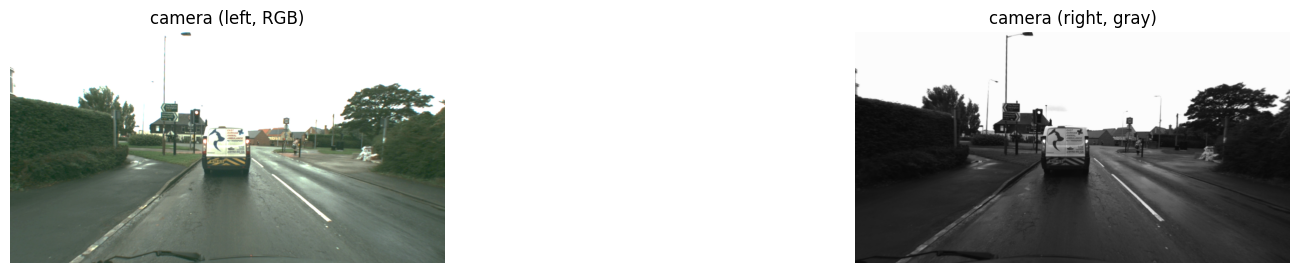

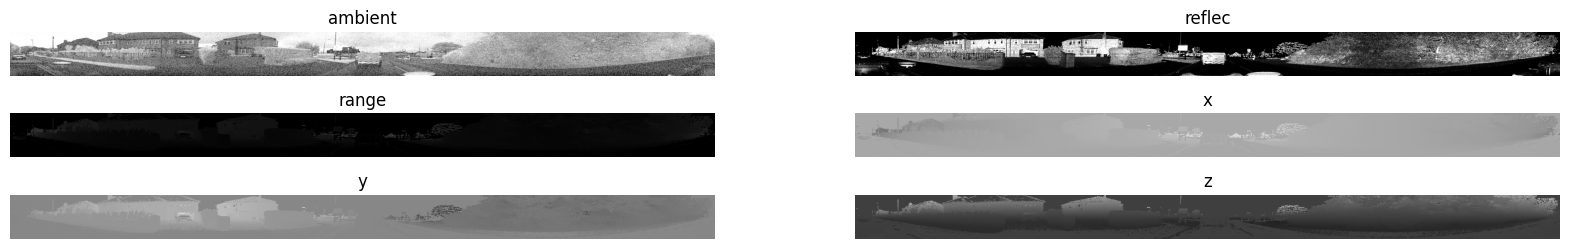

In [ ]:
pano_images = []
for img_path in PANO_IMAGE_PATHS:
    pano_image = cv2.imread(img_path)
    pano_images.append(pano_image)

sv.plot_images_grid(
    images=cam_images_bgr,
    grid_size=(1, 2),
    size=(20, 3),
    titles=['camera (left, RGB)', 'camera (right, gray)']
)

sv.plot_images_grid(
    images=pano_images,
    grid_size=(3, 2),
    size=(20, 3),
    titles=['ambient', 'reflec', 'range', 'x', 'y', 'z']
)

From the above figure, we can see that panoramic images (i.e., ambient, reflectivity, range, …, z) have a broader field of view compared to camera images (i.e., they can see not only the front but also the sides and rear, etc.).

Similar to the previous process of segmenting camera images using SAM, we will now use SAM to directly segment panoramic images.

In [ ]:
pano_images_bgr, pano_sam_results = generate_sam_masks(PANO_IMAGE_PATHS)

SAM mask has been generated: /content/durlar_data/0000000189/0000000189_ambient.png
SAM mask has been generated: /content/durlar_data/0000000189/0000000189_reflec.png
SAM mask has been generated: /content/durlar_data/0000000189/0000000189_range.png
SAM mask has been generated: /content/durlar_data/0000000189/0000000189_x.png
SAM mask has been generated: /content/durlar_data/0000000189/0000000189_y.png
SAM mask has been generated: /content/durlar_data/0000000189/0000000189_z.png


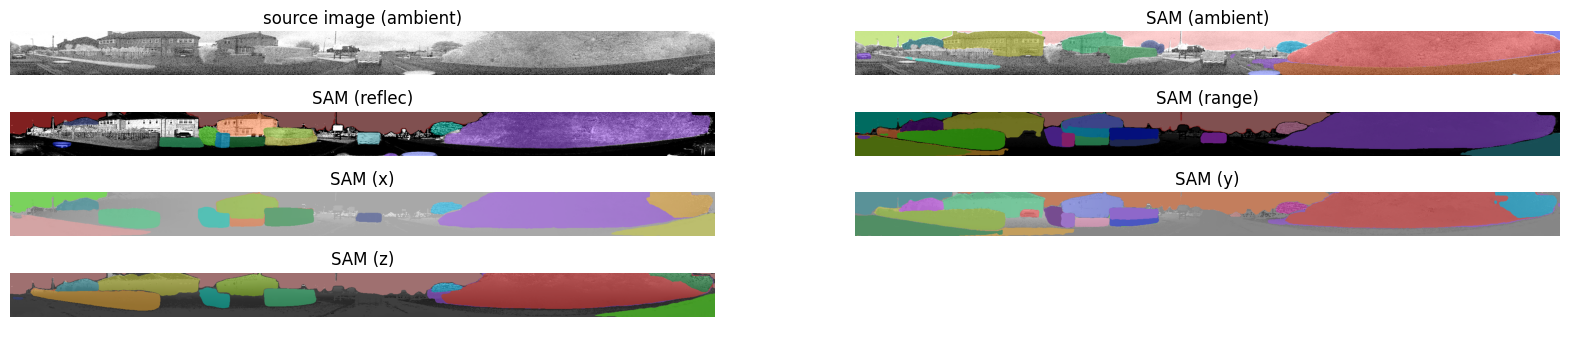

In [ ]:
pano_annotated_images = []
for idx, sam_result in enumerate(pano_sam_results):

    mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

    detections = sv.Detections.from_sam(sam_result=sam_result)

    pano_annotated_images.append(mask_annotator.annotate(scene=pano_images_bgr[idx].copy(), detections=detections))

pano_annotated_images.insert(0, pano_images_bgr[0])
sv.plot_images_grid(
    images=pano_annotated_images,
    grid_size=(4, 2),
    size=(20, 4),
    titles=['source image (ambient)', 'SAM (ambient)', 'SAM (reflec)', 'SAM (range)', 'SAM (x)', 'SAM (y)', 'SAM (z)']
)

The above figure shows that different types of panoramic images yield different segmentation results. Due to the high noise in LiDAR data, low image resolution, and insufficient training of SAM on range images, etc, the segmentation results of SAM on panoramic images are significantly poorer than those on camera images.

## Example: Multi-modality Fusion

To integrate the segmentation results from different types of panoramic images, we can design various fusion methods to achieve better results. For instance, we demonstrate/visualize the simplest approach -- stacking SAM masks to reduce the areas that SAM fails to label.

In [ ]:
masks_with_alpha = []
for idx, sam_result in enumerate(pano_sam_results):

    image_shape = pano_images_bgr[idx].shape
    same_size_array = np.zeros(image_shape, dtype=np.uint8)

    mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

    detections = sv.Detections.from_sam(sam_result=sam_result)
    mask = mask_annotator.annotate(scene=same_size_array.copy(), detections=detections)
    mask_with_alpha = np.zeros((image_shape[0], image_shape[1], 4), dtype=np.uint8)
    mask_with_alpha[..., :3] = mask
    mask_with_alpha[..., 3] = 255

    black_pixels = (mask == [0, 0, 0]).all(axis=-1)
    mask_with_alpha[black_pixels, 3] = 0

    masks_with_alpha.append(mask_with_alpha)

In [ ]:
def alpha_blend_images(images):
    """
    Stack multiple images with transparent channels into one image
    :param images: list of RGBA images (numpy arrays)
    :return: blended image (numpy array)
    """
    # Assuming all images have the same shape
    height, width, channels = images[0].shape
    # Initialize the output image with zeros (completely transparent)
    blended_image = np.zeros((height, width, channels), dtype=np.float32)

    for image in images:
        alpha = image[..., 3] / 255.0  # Normalize alpha channel to [0, 1]
        for c in range(3):  # For R, G, B channels
            blended_image[..., c] = blended_image[..., c] * (1 - alpha) + image[..., c] * alpha
        blended_image[..., 3] = blended_image[..., 3] + image[..., 3] * (1 - blended_image[..., 3] / 255.0)

    # Ensure alpha channel is within [0, 255]
    blended_image[..., 3] = np.clip(blended_image[..., 3], 0, 255)

    return blended_image.astype(np.uint8)

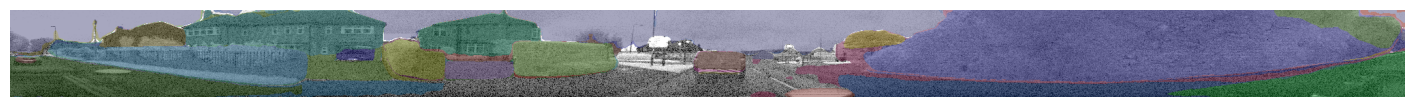

In [ ]:
import matplotlib.pyplot as plt

blended_mask = alpha_blend_images(masks_with_alpha)

ambient_with_alpha = np.zeros((blended_mask.shape[0], blended_mask.shape[1], 4), dtype=np.uint8)
ambient_with_alpha[..., :3] = pano_images_bgr[0]
ambient_with_alpha[..., 3] = 255

blended_mask_2 = np.zeros((blended_mask.shape[0], blended_mask.shape[1], 4), dtype=np.uint8)
blended_mask_2[..., :3] = blended_mask[..., :3]
blended_mask_2[..., 3] = blended_mask[..., 3].copy()*0.5
images = [ambient_with_alpha, blended_mask_2]

seg_image = alpha_blend_images(images)

plt.figure(figsize=(18, 2))
plt.imshow(seg_image)
plt.axis('off')
plt.show()

## Insights

In addition to this example, we also provide one frame from the DurLAR dataset (in the `0000000171` folder). Please feel free to have a quick test.

- You can choose other VFM.
- You can experiment with different 3D-to-2D methods (such as converting the 3D point cloud to BEV instead of panoramic imagery) to fully utilize 2D VFMs.
- You can use or design 2D-to-3D methods to transfer SAM results onto the 3D point cloud.
- You can try VFM on different datasets on different tasks.
- You can try to fuse results obtained from different VFM.
- You can employ various multi-modal fusion methods.
- You can use the results from VFM for various autonomous driving tasks, such as semantic segmentation, object detection, and more.


**The potential of VFM is limitless; you can always discover more...**

## Useful Links

- DurLAR dataset (open-accessed): https://github.com/l1997i/DurLAR?tab=readme-ov-file#get-started
- DurLAR paper: https://arxiv.org/abs/2406.10068
- SAM: https://segment-anything.com/
- Other vision foundation models: https://roboflow.com/model-feature/foundation-vision
- how-to-segment-anything-with-sam: https://github.com/roboflow/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb